In [1]:
import sys
sys.path.append("../..")

import os

if "KERAS_BACKEND" not in os.environ:
    # set this to "torch", "tensorflow", or "jax"
    os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import pickle
import plotting
import datetime
import importlib
from dataclasses import dataclass
from pathlib import Path
from typing import Literal

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import keras

import bayesflow as bf
# bf.diagnostics.plots.calibration_histogram

import utils
importlib.reload(utils)

INFO:bayesflow:Using backend 'tensorflow'


<module 'utils' from '/Users/r/Documents/stud/2025/ls3/bayesflow/my_stuff/code/utils.py'>

In [3]:
FROM_SCRATCH = False


@dataclass
class Config:
    seed: int = 2025
    # correction_method: Literal["taylor", "finetuned", "postflow"] = "finetuned"
    misspec_strength: int = 1


CONFIG = Config()
CONFIG

Config(seed=2025, misspec_strength=1)

In [4]:
OUT_DIR = Path("../data/out/SIR")
OUT_DIR.mkdir(exist_ok=True, parents=True)
IMG_OUT_DIR = OUT_DIR / "images"
IMG_OUT_DIR.mkdir(exist_ok=True, parents=True)

## Defining the Simulator <a class="anchor" id="defining_the_generative"></a>

In [5]:
keras.utils.set_random_seed(CONFIG.seed)
RNG = np.random.default_rng(CONFIG.seed)

In [6]:
def prior():
    """Generates a random draw from the joint prior."""

    lambd = RNG.lognormal(mean=np.log(0.4), sigma=0.5)
    mu = RNG.lognormal(mean=np.log(1 / 8), sigma=0.2)
    D = RNG.lognormal(mean=np.log(8), sigma=0.2)
    I0 = RNG.gamma(shape=2, scale=20)
    psi = RNG.exponential(5)
    return {"lambd": lambd, "mu": mu, "D": D, "I0": I0, "psi": psi}

### Observation Model (Implicit Likelihood Function) <a class="anchor" id="simulator__implicit_likelihood"></a>

### Time-Varying Reporting Rate (System Capacity Model)

**The Rationale:** In the early days of an epidemic, testing capacity is limited. As time goes on, capacity ramps up, and a larger fraction of the true new infections (`I_new`) are officially reported. The true model assumes a constant reporting rate (implicitly 100%) with a fixed delay `D`. A realistic misspecification is that the reporting rate itself is changing over time.

**The Implementation:** We keep the core SIR dynamics (`S`, `I`, `R`, and the true `I_new`) exactly the same as the true model. The misspecification happens only in the "observation" step, by modulating the expected cases before they are fed into the noise model.

We introduce a logistic function for the reporting rate `rho(t)` that grows over the simulation period.

The original expected cases are:
`expected_cases = np.clip(np.array(C[D:]), 0, N)`

The misspecified expected cases will be:
`rho_t = rho_min + (rho_max - rho_min) / (1 + np.exp(-k * (np.arange(T) - t_mid)))`
`expected_cases = rho_t * np.clip(np.array(C[D:]), 0, N)`

Here, `rho_min`, `rho_max`, `k` (steepness), and `t_mid` (midpoint of growth) are new, **fixed** parameters of the misspecified model, not part of `w`. For example, you could model the reporting rate growing from 30% to 80% over the first 14 days. The inference process, assuming a constant reporting rate, would be forced to infer a strange, time-varying `lambd` to explain this trend, resulting in a biased posterior.


In [7]:

def convert_params(mu, phi):
    """Helper function to convert mean/dispersion parameterization of a negative binomial to N and p,
    as expected by numpy's negative_binomial.

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    # Prevent division by zero or invalid values
    phi = np.maximum(phi, 1e-9)
    mu = np.maximum(mu, 1e-9)

    r = phi
    var = mu + 1 / r * mu**2
    p = (var - mu) / var
    return r, 1 - p


def stationary_SIR(lambd, mu, D, I0, psi, N=83e6, T=14, eps=1e-5, rho_min=1.0, rho_max=1.0, k=1.0, t_mid=7, decay_rate=0.0):
    """
    The TRUE model (M).
    Performs a forward simulation from the standard stationary SIR model.
    """
    # Extract parameters and round I0 and D
    I0 = np.ceil(I0)
    D = int(round(D))

    # Initial conditions
    S, I, R = [N - I0], [I0], [0]

    # True new cases
    C_true = [I0]

    # Simulate T-1 timesteps
    for t in range(1, T + D):
        susceptible_fraction = S[-1] / N
        lambda_t = lambd * np.exp(-decay_rate * t)
        
        # Calculate new cases using standard mass-action
        I_new = lambda_t * I[-1] * susceptible_fraction

        # SIR equations
        S_t = S[-1] - I_new
        I_t = np.clip(I[-1] + I_new - mu * I[-1], 0.0, N)
        R_t = np.clip(R[-1] + mu * I[-1], 0.0, N)

        # Track
        S.append(S_t)
        I.append(I_t)
        R.append(R_t)
        C_true.append(I_new)
    
    # Apply observation model
    rho_t = rho_min + (rho_max - rho_min) / (1 + np.exp(-k * (np.arange(T) - t_mid)))
    expected_cases = rho_t * np.clip(np.array(C_true[D:]), 0, N) + eps
    reparam = convert_params(expected_cases, psi)
    C_obs = RNG.negative_binomial(reparam[0], reparam[1])
    return dict(cases=C_obs)


def stationary_SIR_misspecified(*args, **kwargs):
    misspec_dict = dict(
        rho_min=0.2,
        rho_max=0.7,
        k=1.0,
        t_mid=7
    )
    if CONFIG.misspec_strength == 1:
        ...
    elif CONFIG.misspec_strength == 2:
        misspec_dict["k"] = 2.0
    elif CONFIG.misspec_strength == 3:
        misspec_dict["k"] = 3.0
    else:
        raise ValueError("Too large")
    return stationary_SIR(*args, **(kwargs | misspec_dict))

In [8]:
def load_data():
    """Helper function to load cumulative cases and transform them to new cases."""

    confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    confirmed_cases = pd.read_csv(confirmed_cases_url, sep=",")

    date_data_begin = datetime.date(2020, 3, 1)
    date_data_end = datetime.date(2020, 3, 15)
    format_date = lambda date_py: f"{date_py.month}/{date_py.day}/{str(date_py.year)[2:4]}"
    date_formatted_begin = format_date(date_data_begin)
    date_formatted_end = format_date(date_data_end)

    cases_obs = np.array(
        confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", date_formatted_begin:date_formatted_end]
    )[0]
    new_cases_obs = np.diff(cases_obs)
    return new_cases_obs

In [9]:
def plot_sir_misspecification():
    fig, ax = plotting.get_ax_grid(1, 1, sharey=True)
    ax.set_xlabel("Days")
    ax.set_yscale("log")
    ax.set_ylabel("Number of cases")

    SIR_PARAMS = (0.4, 0.12, 8, 26, 5.0)
    cases_true_model = np.array([
        stationary_SIR(*SIR_PARAMS)["cases"] for _ in range(200)
    ])
    cases_miss_model = np.array([
        stationary_SIR_misspecified(*SIR_PARAMS)["cases"] for _ in range(200)
    ])
    
    # ax.plot(load_data(), "ro-", zorder=100, alpha=0.6)
    x = np.arange(len(cases_true_model[0]))
    ax.plot(x, np.median(cases_true_model, axis=0), "k-o", label="Simulator")
    ax.plot(x, np.median(cases_miss_model, axis=0), "-s", color="C0", label="Surrogate", mec="k")
    for alpha, q in zip([0.5, 0.3, 0.1], [0.25, 0.05, 0.025]):
        ax.fill_between(x, *np.quantile(cases_true_model, [q, 1-q], axis=0), color="k", alpha=alpha)
        ax.fill_between(x, *np.quantile(cases_miss_model, [q, 1-q], axis=0), color="C0", alpha=alpha)
    ax.fill_between([], [], [], color="grey", label="50/90/95% CI")
    ax.legend()
    return fig

'/Users/r/Documents/stud/2025/ls3/bayesflow/my_stuff/data/out/SIR/images/simSur_misStrength=1'

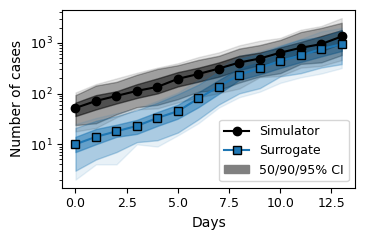

In [51]:
importlib.reload(plotting)
fig = plot_sir_misspecification()
img_path = IMG_OUT_DIR / f"simSur_misStrength={CONFIG.misspec_strength}"
plotting.savefig(fig, img_path)
str(img_path.resolve())

### Stitiching Things Together <a class="anchor" id="generative_model"></a>
We can combine the prior $p(\theta)$ and the observation model $p(x_{1:T}\mid\theta)$ into a joint model $p(\theta, x_{1:T}) = p(\theta) \; p(x_{1:T}\mid\theta)$ using the `make_simulator` builder.
The resulting object can now generate *batches* of simulations.

In [11]:
simulator = bf.make_simulator([prior, stationary_SIR])
simulator_misspecified = bf.make_simulator([prior, stationary_SIR_misspecified])

In [12]:
adapter = (
    bf.adapters.Adapter()
    .convert_dtype("float64", "float32")
    .as_time_series("cases")
    .concatenate(["lambd", "mu", "D", "I0", "psi"], into="inference_variables")
    .rename("cases", "summary_variables")
    # since all our variables are non-negative (zero or larger), the next call transforms them
    # to the unconstrained real space and can be back-transformed under the hood
    .log(["inference_variables", "summary_variables"], p1=True)
)

In [13]:
# Let's check out the new shapes
adapted_sims = adapter(simulator.sample(2))
print(adapted_sims["summary_variables"].shape)
print(adapted_sims["inference_variables"].shape)

(2, 14, 1)
(2, 5)


## Defining the Neural Approximator <a class="anchor" id="defining_the_neural"></a>

We can now proceed to define our `BayesFlow` neural architecture, that is, combine a summary network with an inference network.

### Summary Network <a class="anchor" id="summary_network"></a>

Since our simulator outputs 3D tensors of shape ``(batch_size, T = 14, 1)``, we need to reduce this three-dimensional tensor into a two-dimensional tensor of shape ``(batch_size, summary_dim)``. Our model outputs are actually so simple that we could have just removed the trailing dimension of the raw outputs and simply fed the data directly to the inference network.

However, we demonstrate the use of a simple Gated Recurrent Unit (GRU) summary network. Any `keras` model can interact with `BayesFlow` by inherting from `SummaryNetwork` which accepts an addition `stage` argument indicating the mode the network is currently operating in (i.e., `training` vs. `inference`).

In [14]:
@keras.saving.register_keras_serializable()
class NoGru(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, time_series, **kwargs):
        summary = time_series[..., 0]
        return summary


@keras.saving.register_keras_serializable()
class GRU(bf.networks.SummaryNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.gru = keras.layers.GRU(64, dropout=0.1)
        self.summary_stats = keras.layers.Dense(8)
        
    def call(self, time_series, **kwargs):
        """Compresses time_series of shape (batch_size, T, 1) into summaries of shape (batch_size, 8)."""

        summary = self.gru(time_series, training=kwargs.get("stage") == "training")
        summary = self.summary_stats(summary)
        return summary


### Inference Network

### Workflow
Inference with workflows is easy. Simply provide the simulator, adapter, and network objects, and have fun! If you want to save the networks automatically after training, provide a `checkpoint_filepath` and an optional `checkpoint_name`.

In [15]:
workflow = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=GRU(),
    standardize=None # no need to standardize due to log-transform
)
workflow_misspecified = bf.BasicWorkflow(
    simulator=simulator_misspecified,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=GRU(),
    standardize=None
)

# Training <a class="anchor" id="training"></a>

In [16]:
# full-budget (fb) training
training_data_fb = workflow.simulate(6000)
validation_data_fb = workflow.simulate(300)

## Full-Budget

In [17]:
FLOW_FB_PATH = OUT_DIR / f"flow_fb.keras"
HIST_FB_PATH = OUT_DIR / f"hist_fb.pickle"
if FLOW_FB_PATH.exists() and not FROM_SCRATCH:
    history = pickle.loads(HIST_FB_PATH.read_bytes())
    workflow.approximator = keras.saving.load_model(FLOW_FB_PATH)
else:
    history = workflow.fit_offline(
        data=training_data_fb, 
        epochs=100,
        batch_size=64, 
        validation_data=validation_data_fb
    )
    HIST_FB_PATH.write_bytes(pickle.dumps(history))
    workflow.approximator.save(FLOW_FB_PATH)

## SABI

In [18]:
training_data_misspecified = workflow_misspecified.simulate(6000)
validation_data_misspecified = workflow_misspecified.simulate(300)

In [19]:
FLOW_MIS_PATH = OUT_DIR / f"flow_misStrengh={CONFIG.misspec_strength}.keras"
HIST_MIS_PATH = OUT_DIR / f"hist_misStrengh={CONFIG.misspec_strength}.pickle"
if FLOW_MIS_PATH.exists() and not FROM_SCRATCH:
    history_mis = pickle.loads(HIST_MIS_PATH.read_bytes())
    workflow_misspecified.approximator = keras.saving.load_model(FLOW_MIS_PATH)
else:
    history_mis = workflow_misspecified.fit_offline(
        data=training_data_misspecified, 
        epochs=100,
        batch_size=64, 
        validation_data=validation_data_misspecified
    )
    HIST_MIS_PATH.write_bytes(pickle.dumps(history_mis))
    workflow_misspecified.approximator.save(FLOW_MIS_PATH)

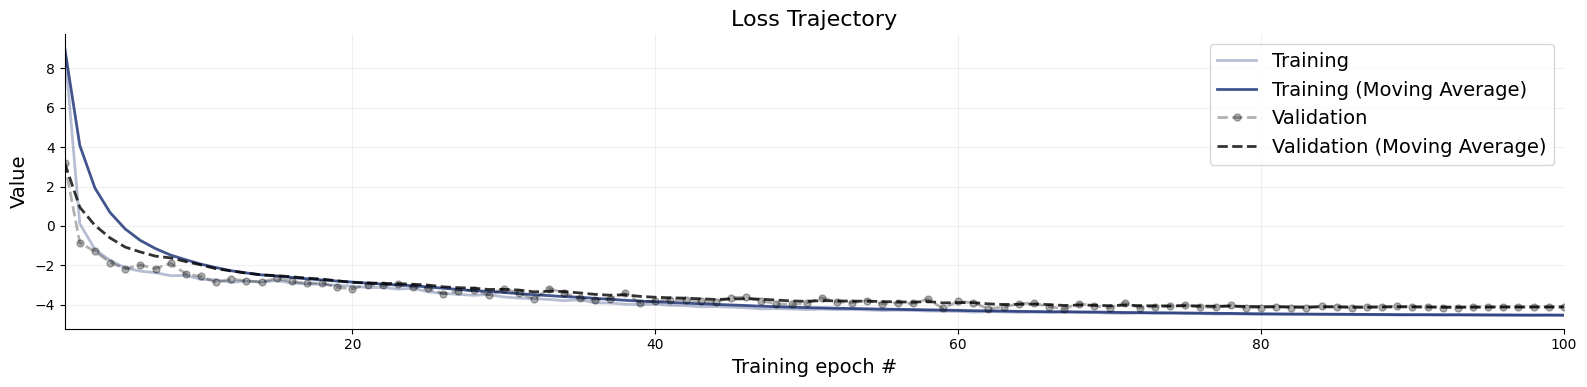

In [20]:
f = bf.diagnostics.plots.loss(history_mis)

In [21]:
# colloc_data = workflow.simulate(25)  # was good for everything except postflow
colloc_data = workflow.simulate(42)
colloc_w = pd.DataFrame({k: v.squeeze() for k, v in colloc_data.items() if k != "cases"}).to_numpy()
colloc_w.shape

(42, 5)

In [22]:
def eval_surr_at_collocs():
    df = pd.DataFrame({k: v.squeeze() for k, v in colloc_data.items() if k != "cases"})
    sims = []
    for _, series in df.iterrows():
        sims.append(stationary_SIR_misspecified(**series.to_dict())["cases"])
    sims = np.array(sims)
    d = {
    k: np.copy(v) for k, v in colloc_data.items()
    }
    d["cases"] = sims
    return d

colloc_err = colloc_data["cases"] - eval_surr_at_collocs()["cases"]
colloc_err.shape

(42, 14)

## GP construction

In [23]:
# import gptools
# import importlib
# importlib.reload(gptools)

# gps = gptools.train_gp_sir(colloc_err.astype(float), colloc_w, CONFIG.seed)
# gps

## Low-Budget

In [24]:
workflow_lb = bf.BasicWorkflow(
    simulator=simulator,
    adapter=adapter,
    inference_network=bf.networks.CouplingFlow(),
    summary_network=GRU(),
    standardize=None # no need to standardize due to log-transform
)

FLOW_LB_PATH = OUT_DIR / f"flow_LB.keras"
HIST_LB_PATH = OUT_DIR / f"hist_LB.pickle"
if FLOW_LB_PATH.exists() and not FROM_SCRATCH:
    history_lb = pickle.loads(HIST_LB_PATH.read_bytes())
    workflow_lb.approximator = keras.saving.load_model(FLOW_LB_PATH)
else:
    history_lb = workflow_lb.fit_offline(
        data=colloc_data, 
        epochs=100,
        batch_size=64,
    )
    HIST_LB_PATH.write_bytes(pickle.dumps(history_lb))
    workflow_lb.approximator.save(FLOW_LB_PATH)

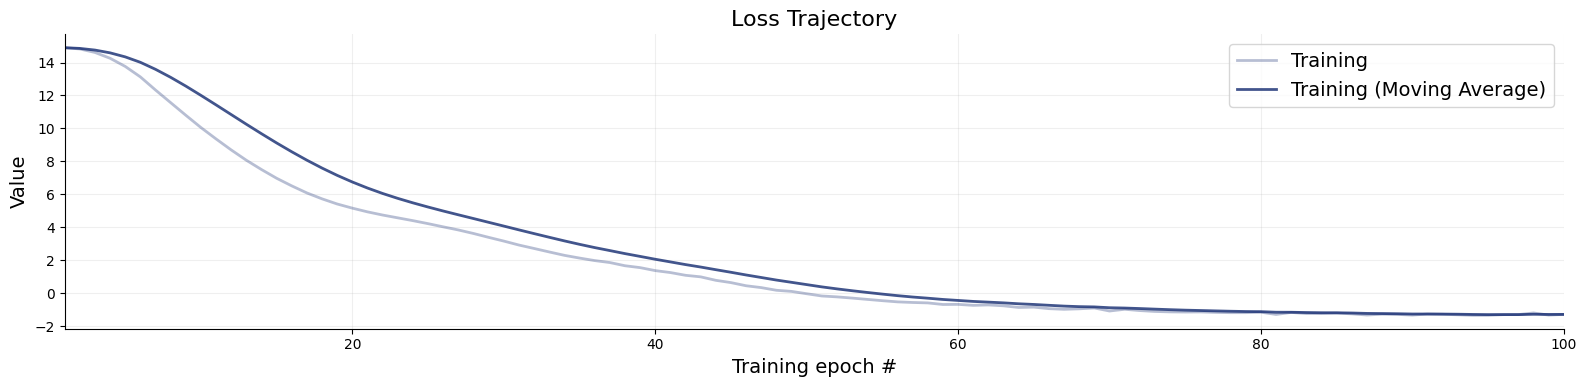

In [25]:
f = bf.diagnostics.plots.loss(history_lb)

## Correction

In [26]:
def get_trained_correction_workflow(correction_method: str):

    if correction_method == "finetuned":
        workflow_corrected = bf.BasicWorkflow(
            simulator=simulator_misspecified,
            adapter=adapter,
            inference_network=keras.saving.load_model(FLOW_MIS_PATH).inference_network,
            summary_network=keras.saving.load_model(FLOW_MIS_PATH).summary_network,
            initial_learning_rate=0.5*5e-4,  # half of the default
            standardize=None
        )
        # workflow_corrected still has simulator_misspecified because
        # 1. it does not really matter since the simulator of the workflow is only used when we call workflow.simulate, which will evaluate the simulator on random prior points. But we don't use this since we can generate these with the true workflow or the misspecified anyways
        # 2. it would be a potential for bugs since exposing the true simulator, which we can conceptually only evaluate a few times, could lead to accidentally using it which is not desired.


    elif correction_method == "postflow":
        # 1. Load the entire pre-trained approximator
        pre_trained_approximator = keras.saving.load_model(FLOW_MIS_PATH)
        
        # 2. Extract the components
        base_inference_net = pre_trained_approximator.inference_network
        shared_summary_net = pre_trained_approximator.summary_network
        
        # 3. Freeze the weights of both pre-trained components.
        # NOTE: I tried with letting it train but it did not improve anything
        shared_summary_net.trainable = True
        
        # 4. Build the corrected workflow with the frozen components
        workflow_corrected = bf.BasicWorkflow(
            simulator=simulator_misspecified,
            adapter=adapter,
            inference_network=bf.networks.DoubleCouplingFlow(
                depth=2,
                subnet_kwargs={"widths": (32, 32)},
                base_distribution=base_inference_net
                # The base_inference_net will be set to trainable=False inside this class
            ),
            summary_network=shared_summary_net,
            initial_learning_rate=5e-4,
            standardize=None
        )
        
    elif correction_method == "taylor":

        def get_high_fidelity_data():
            y_colloc = workflow.adapter(colloc_data)["summary_variables"]  # type: ignore
            y_delta = (workflow.adapter(colloc_data)["summary_variables"] - workflow.adapter(eval_surr_at_collocs())["summary_variables"])  # type: ignore
            return [
                workflow.adapter(colloc_data)["inference_variables"],  # type: ignore
                # workflow_misspecified.summary_network(y_colloc),  
                # workflow_misspecified.summary_network(y_delta)
                y_colloc,  
                y_delta
            ]

        _summ_net = NoGru()
        workflow_corrected = bf.BasicWorkflow(
            simulator=simulator_misspecified,
            adapter=adapter,
            inference_network=bf.networks.FlowMatching(
                high_fidelity_data=get_high_fidelity_data()
            ),
            summary_network=_summ_net,
            initial_learning_rate=5e-4,  # default
            standardize=None
        )
        workflow_corrected.inference_network.summary_net = _summ_net
    

    # Training -----------------
    correction_train_kwargs = dict()

    if correction_method == "finetuned":
        correction_train_kwargs = dict(
            data=colloc_data,
            epochs=40,
            batch_size=64,
        )

    if correction_method == "postflow":
        correction_train_kwargs = dict(
            data1=training_data_misspecified,
            epochs1=40,
            data=utils.make_data_mix(training_data_misspecified, colloc_data, 0.25, 100),
            epochs=2,
            batch_size=64,
        )

    elif correction_method == "taylor":
        correction_train_kwargs = dict(
            data=training_data_misspecified,
            epochs=100,
            batch_size=64,
        )

    FLOW_CORR_PATH = OUT_DIR / f"flow_misStrengh={CONFIG.misspec_strength}_corrMethod={correction_method}.keras"
    HIST_CORR_PATH = OUT_DIR / f"hist_misStrengh={CONFIG.misspec_strength}_corrMethod={correction_method}.pickle"
    if FLOW_CORR_PATH.exists() and not FROM_SCRATCH:
        history_corrected = pickle.loads(HIST_CORR_PATH.read_bytes())
        workflow_corrected.approximator = keras.saving.load_model(FLOW_CORR_PATH)
    else:
        if "epochs1" in correction_train_kwargs:
            history_corrected = workflow_corrected.fit_offline(
                data=correction_train_kwargs.pop("data1"),
                epochs=correction_train_kwargs.pop("epochs1"),
                batch_size=correction_train_kwargs.get("batch_size", 64),
            )
        history_corrected = workflow_corrected.fit_offline(**correction_train_kwargs)
        HIST_CORR_PATH.write_bytes(pickle.dumps(history_corrected))
        workflow_corrected.approximator.save(FLOW_CORR_PATH)
    
    bf.diagnostics.plots.loss(history_corrected)
    plt.show()

    return workflow_corrected

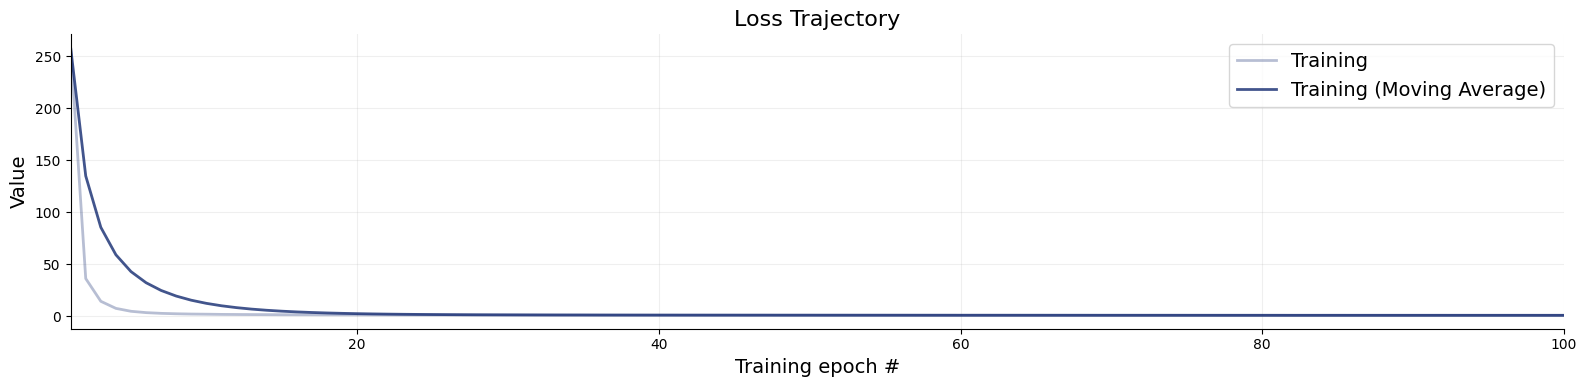

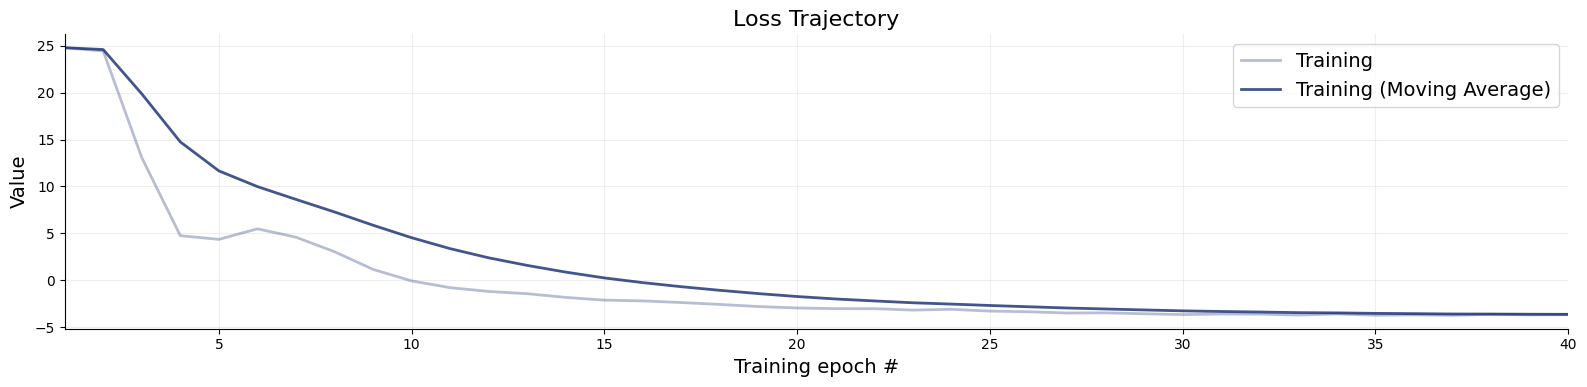

/Users/r/Documents/stud/2025/ls3/bayesflow/.venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 235 variables whereas the saved optimizer has 67 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


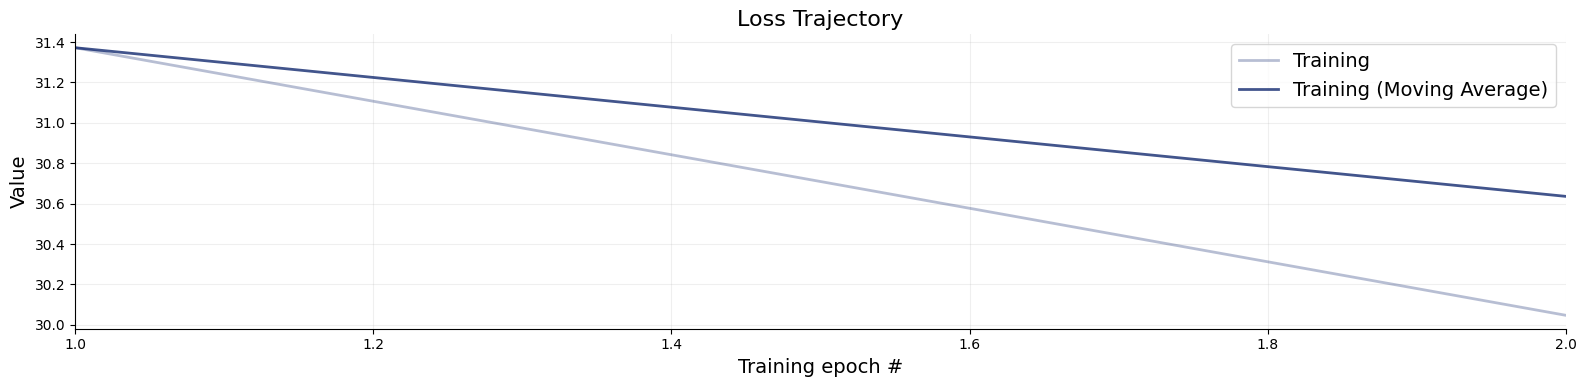

{'Full-Budget': <bayesflow.workflows.basic_workflow.BasicWorkflow at 0x179a942c0>,
 'Low-Budget': <bayesflow.workflows.basic_workflow.BasicWorkflow at 0x179c86ab0>,
 'SABI': <bayesflow.workflows.basic_workflow.BasicWorkflow at 0x179c70f50>,
 'Corrected (taylor)': <bayesflow.workflows.basic_workflow.BasicWorkflow at 0x318744ce0>,
 'Corrected (finetuned)': <bayesflow.workflows.basic_workflow.BasicWorkflow at 0x30efea510>,
 'Corrected (postflow)': <bayesflow.workflows.basic_workflow.BasicWorkflow at 0x319042d20>}

In [27]:
workflows = {
    "Full-Budget": workflow,
    "Low-Budget": workflow_lb,
    "SABI": workflow_misspecified,
}
for correction_method in "taylor", "finetuned", "postflow":
    workflows[f"Corrected ({correction_method})"] = get_trained_correction_workflow(correction_method)

workflows

In [28]:
!say "Training Done"

## Validation Phase

In [29]:
num_datasets = 300
num_samples = 500

# if CONFIG.correction_method == "taylor":
#     # flow matching inference too slow to allow for too many datasets
#     num_datasets = 75
#     num_samples = 500

test_sims = workflow.simulate(num_datasets)
TEST_SIMS_PATH = OUT_DIR / f"testSims.pickle"
TEST_SIMS_PATH.write_bytes(pickle.dumps(test_sims))

posterior_samples_per_wf = {
    wf_name: wf.sample(conditions=test_sims, num_samples=num_samples, steps=40)
    for wf_name, wf in workflows.items()
}

/Users/r/Documents/stud/2025/ls3/bayesflow/my_stuff/code/../../bayesflow/adapters/transforms/log.py:34: RuntimeWarning: overflow encountered in expm1
  return np.expm1(data)


### Simulation-Based Calibration - Rank Histograms

As a further <strong>small world</strong> (i.e., before real data) sanity check, we can also test the calibration of the amortizer through simulation-based calibration (SBC). See the corresponding paper for more details (https://arxiv.org/pdf/1804.06788.pdf). Accordingly, we expect to observe approximately uniform rank statistic histograms. In the present case, this is indeed what we get:

In [30]:
VAR_KEYS = ["lambd", "I0", "psi"]
VAR_NAMES = ["$\\lambda$", "$I_0$", "$\\psi$"]
BFPKW = dict(
    variable_keys=VAR_KEYS,
    variable_names=VAR_NAMES,
)

In [31]:
from bayesflow.diagnostics import plots as bfp

Full-Budget


Low-Budget


SABI


Corrected (taylor)


Corrected (finetuned)


Corrected (postflow)


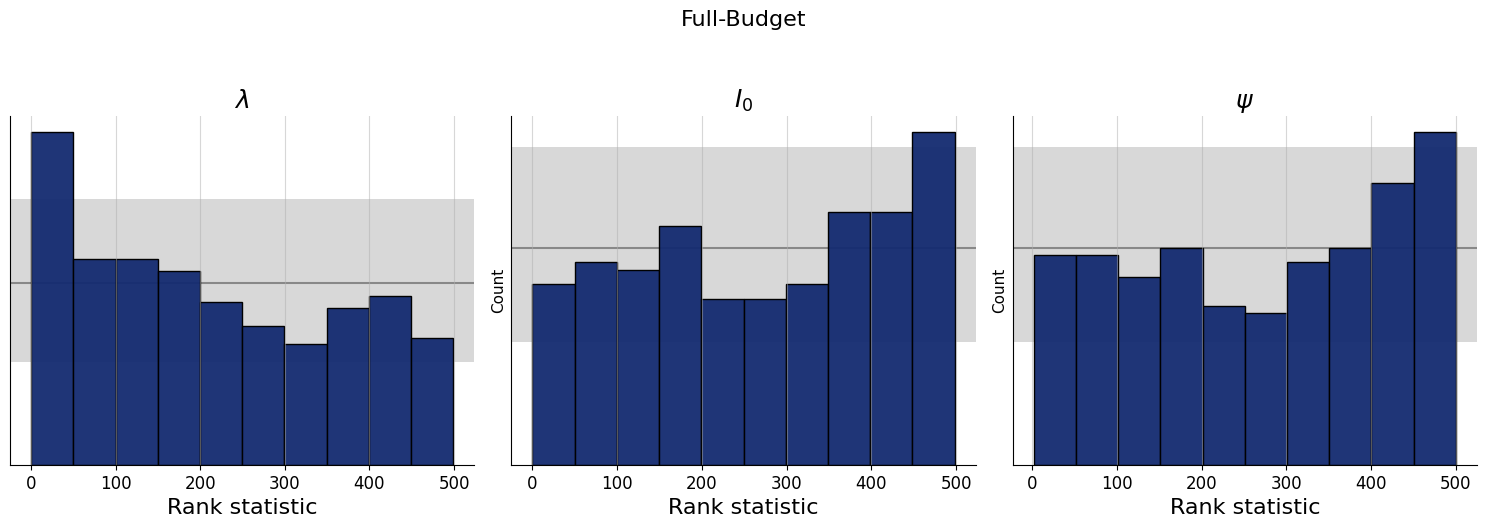

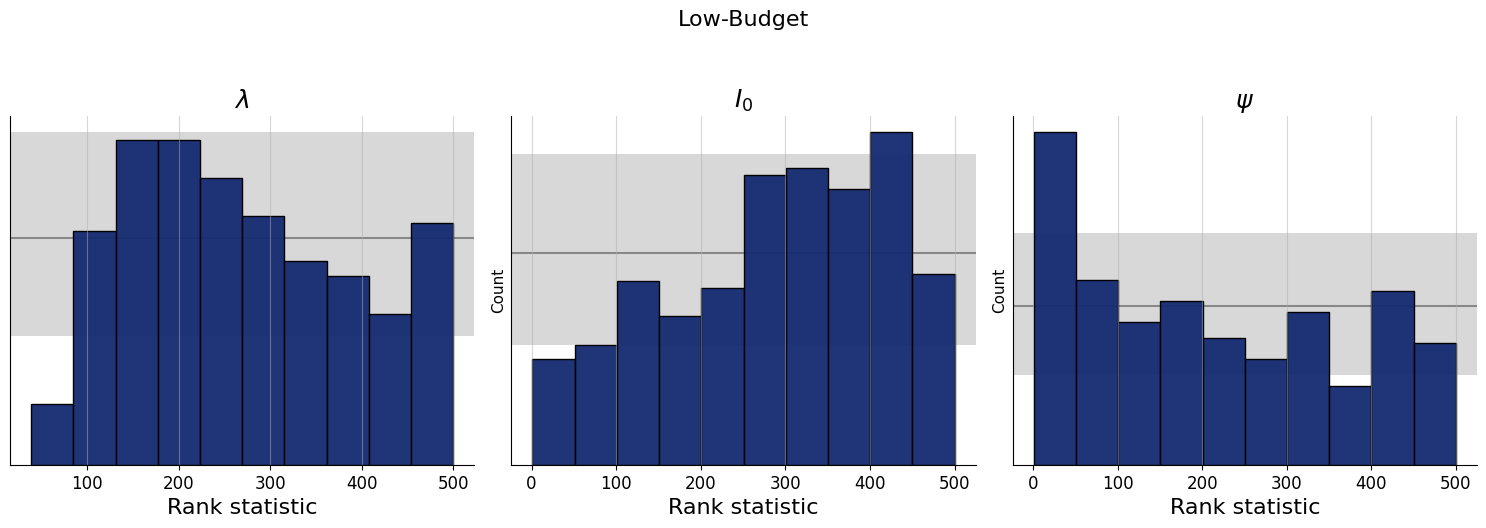

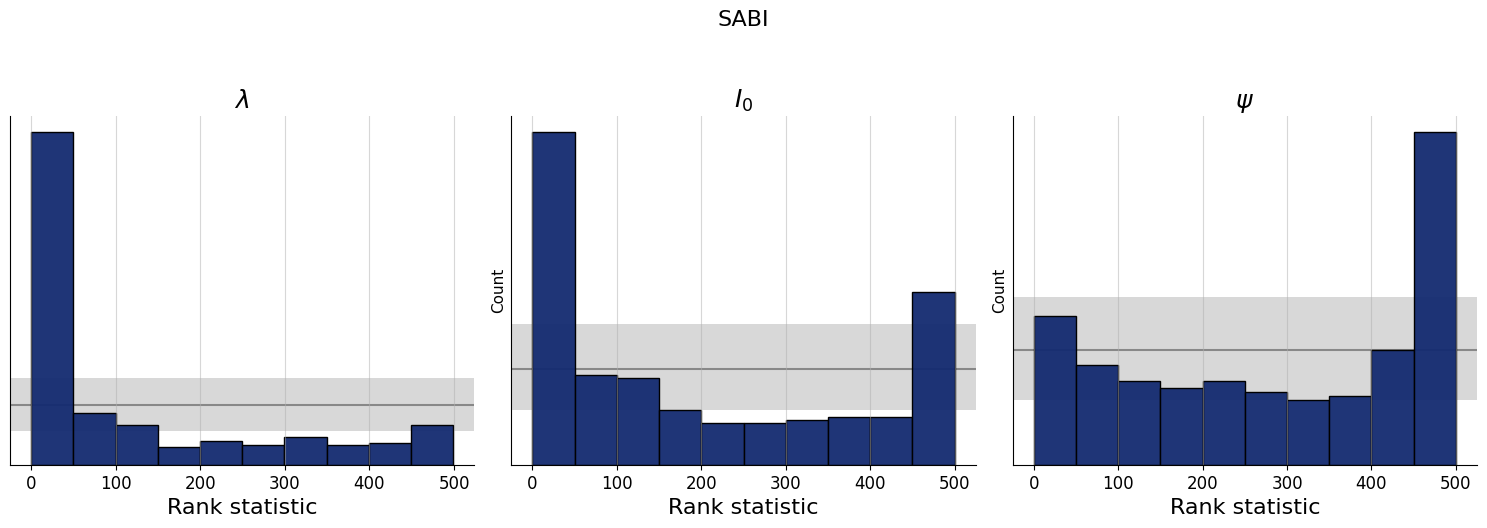

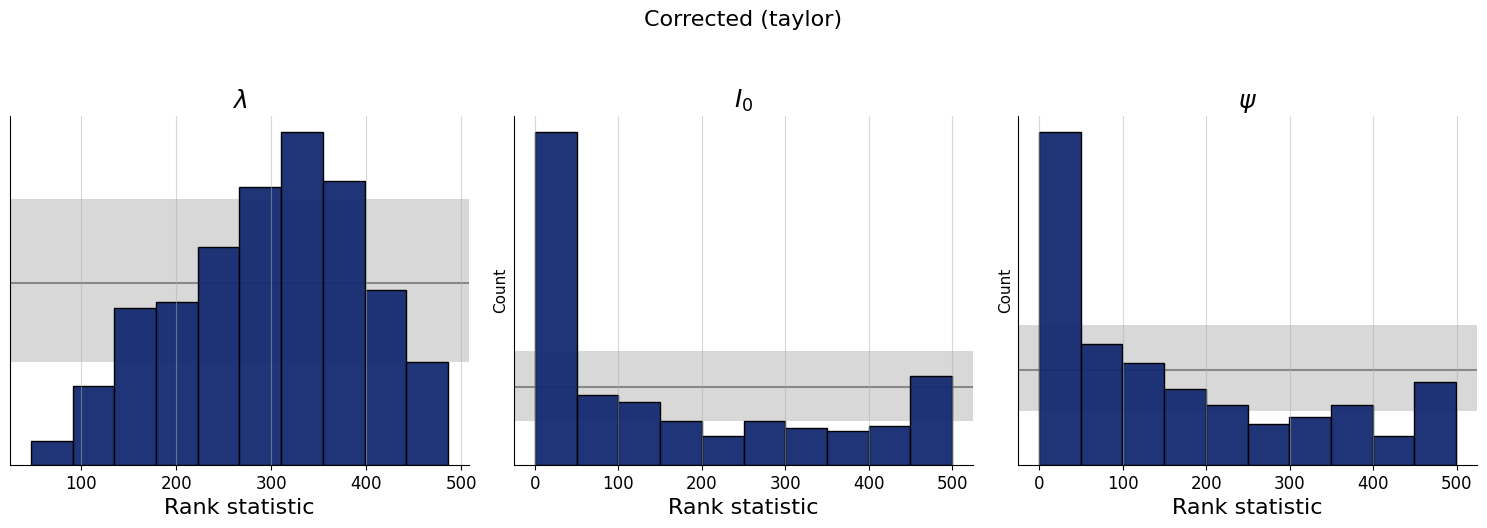

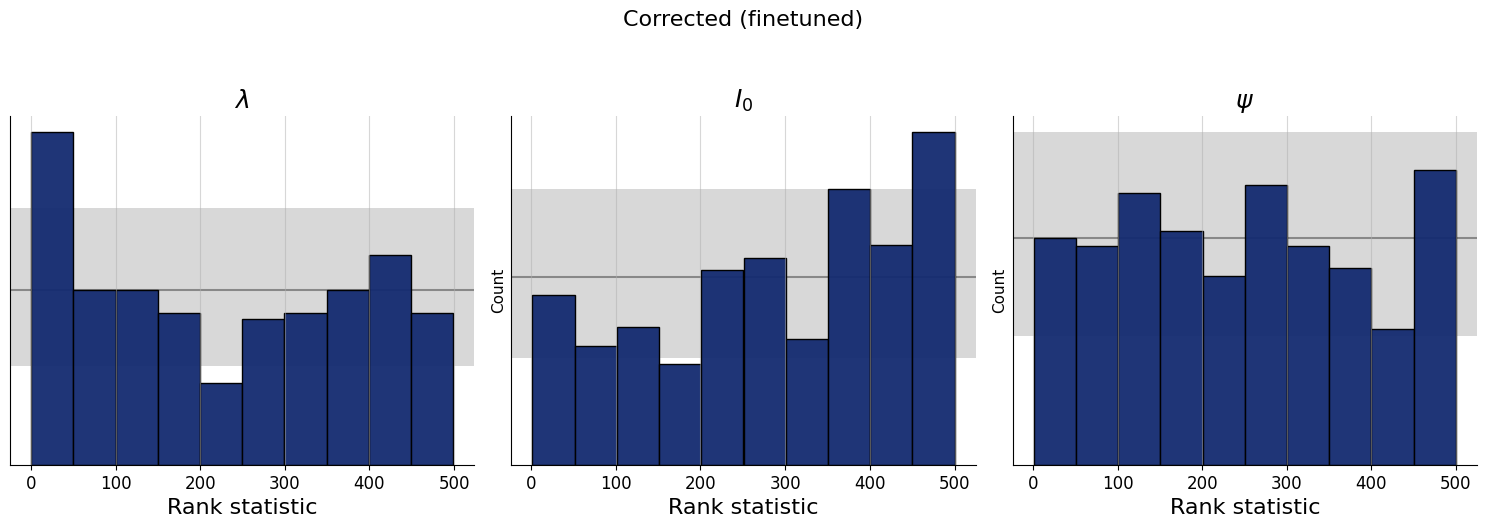

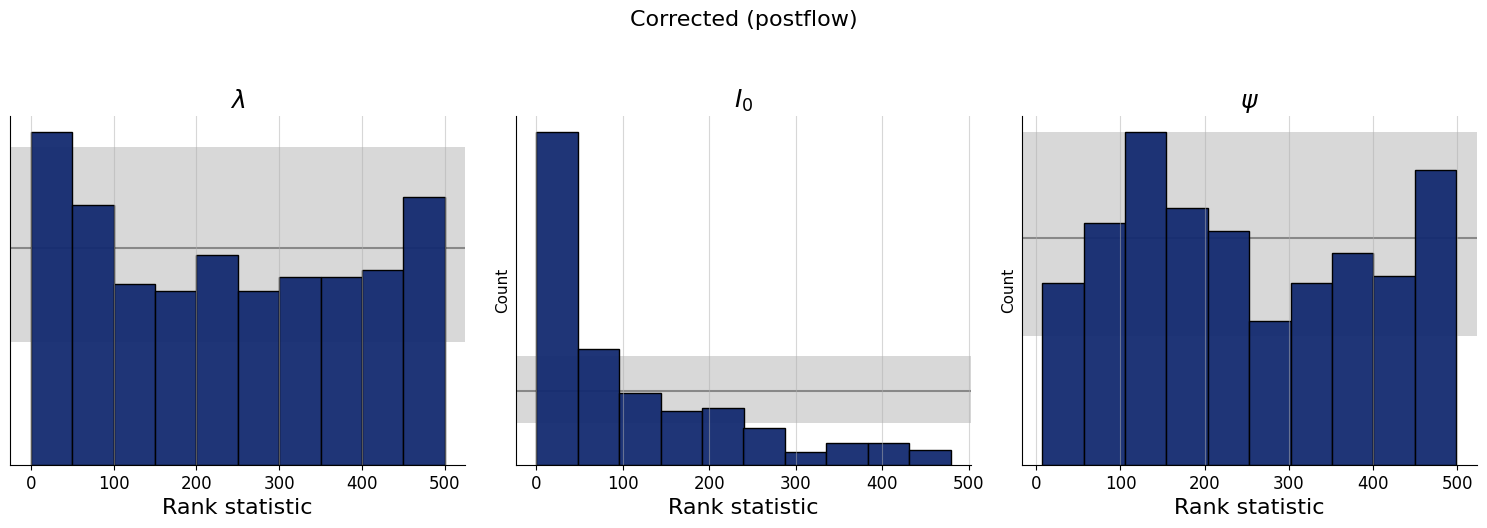

In [32]:
for wf_name, posterior_samples in posterior_samples_per_wf.items():
    print(wf_name)
    POST_SAMPLE_PATH = OUT_DIR / f"postSamples_misStrength={CONFIG.misspec_strength}_{wf_name}.pickle"
    POST_SAMPLE_PATH.write_bytes(pickle.dumps(posterior_samples))
    f = bfp.calibration_histogram(posterior_samples, test_sims, **BFPKW)
    f.suptitle(wf_name, y=1.05, fontsize=16)
    if wf_name not in ["Full-Budget", "Low-Budget"]:
        img_path = IMG_OUT_DIR / f"rankHist_misStrength={CONFIG.misspec_strength}_{wf_name}"
    else:
        img_path = IMG_OUT_DIR / f"rankHist_{wf_name}"
    plotting.savefig(f, img_path)

### Simulation-Based Calibration - Rank ECDF

For models with many parameters, inspecting many histograms can become unwieldly. Moreover, the `num_bins` hyperparameter for the construction of SBC rank histograms can be hard to choose. An alternative diagnostic approach for calibration is through empirical cumulative distribution functions (ECDF) of rank statistics. You can read more about this approach in the corresponding paper (https://arxiv.org/abs/2103.10522).

In order to inspect the ECDFs of marginal distributions, we will simulate $300$ new pairs of simulated data and generating parameters $(\boldsymbol{x}, \boldsymbol{\theta})$ and use the function `plots.calibration_ecdf` from the `diagnostics` module: 

In [33]:
def bfp_better_calibration_legend():
    fig = plt.gcf()
    axs = fig.get_axes()
    for ax in np.ravel(axs):
        if ax.legend_ is not None:
            ax.legend_.remove()
    fig.legend(
        handles=[
            plt.plot([], [], color="#132a70")[0],  # type: ignore
            plt.fill_between([], [], [], color="grey", alpha=0.5)
        ],
        labels=["Rank ECDF", "95% Confidence Bands"],
        fontsize=14,
        loc="upper center",
        bbox_to_anchor=(0.52, 1.1),   # shift above the axes
        ncol=2,
    )

Full-Budget
Low-Budget
SABI
Corrected (taylor)
Corrected (finetuned)
Corrected (postflow)


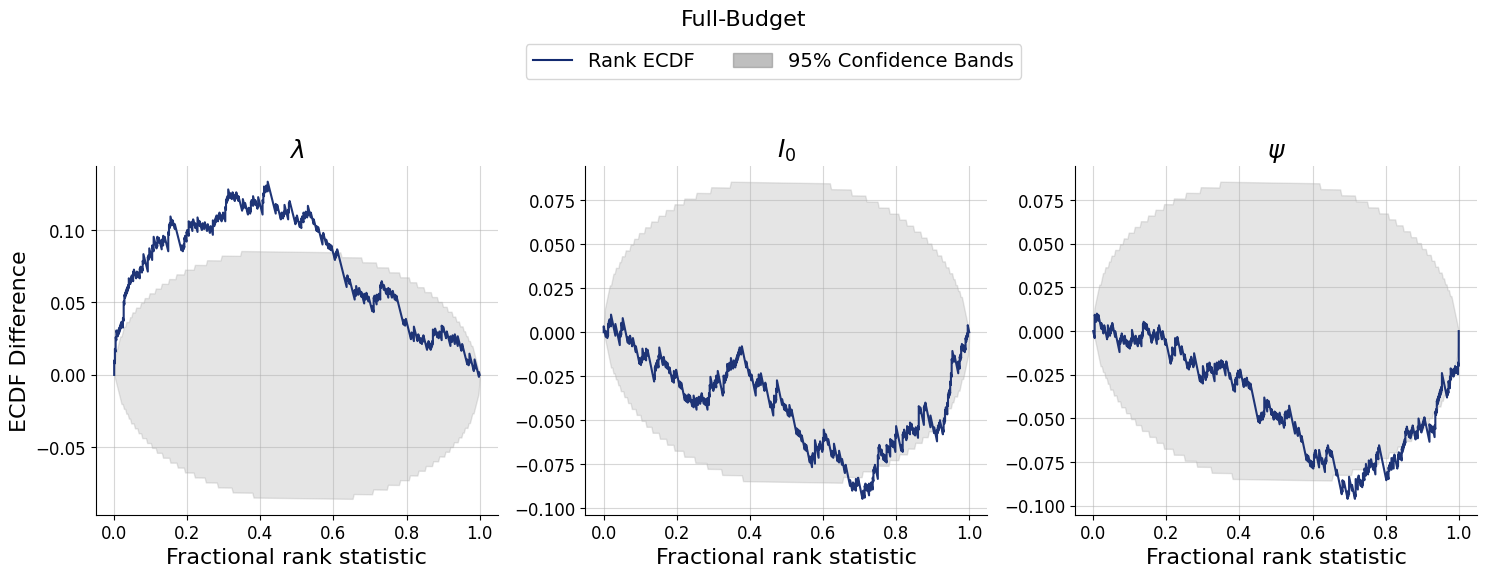

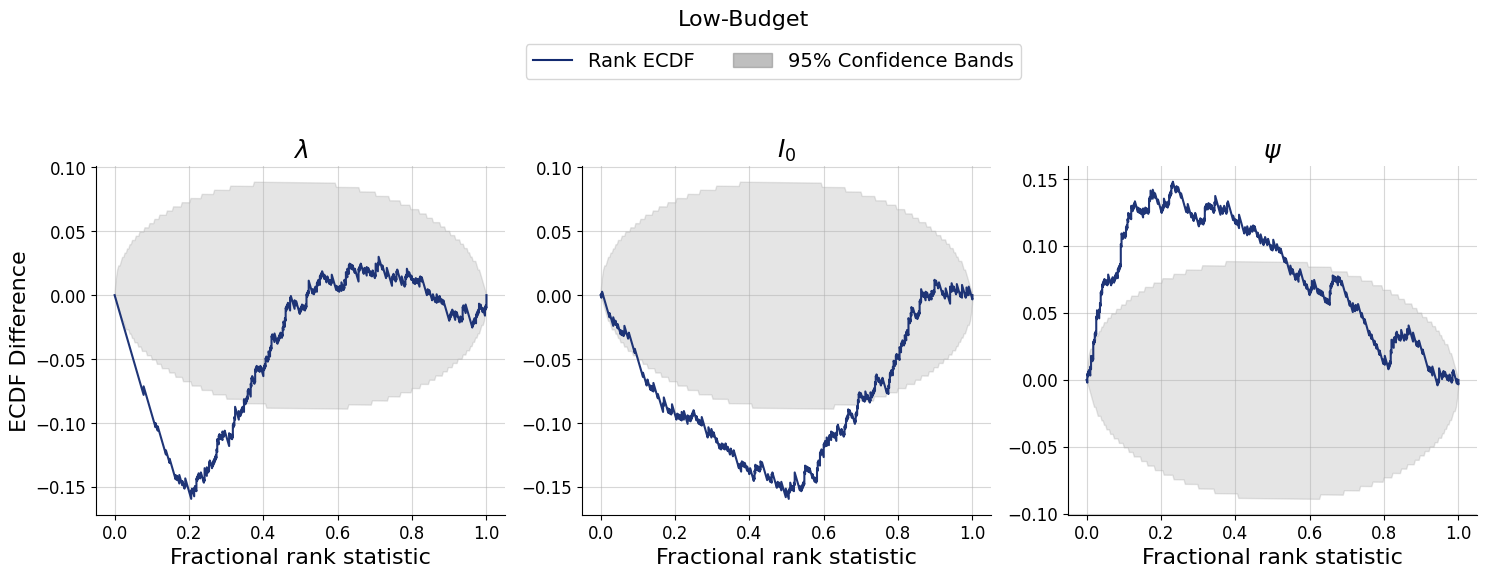

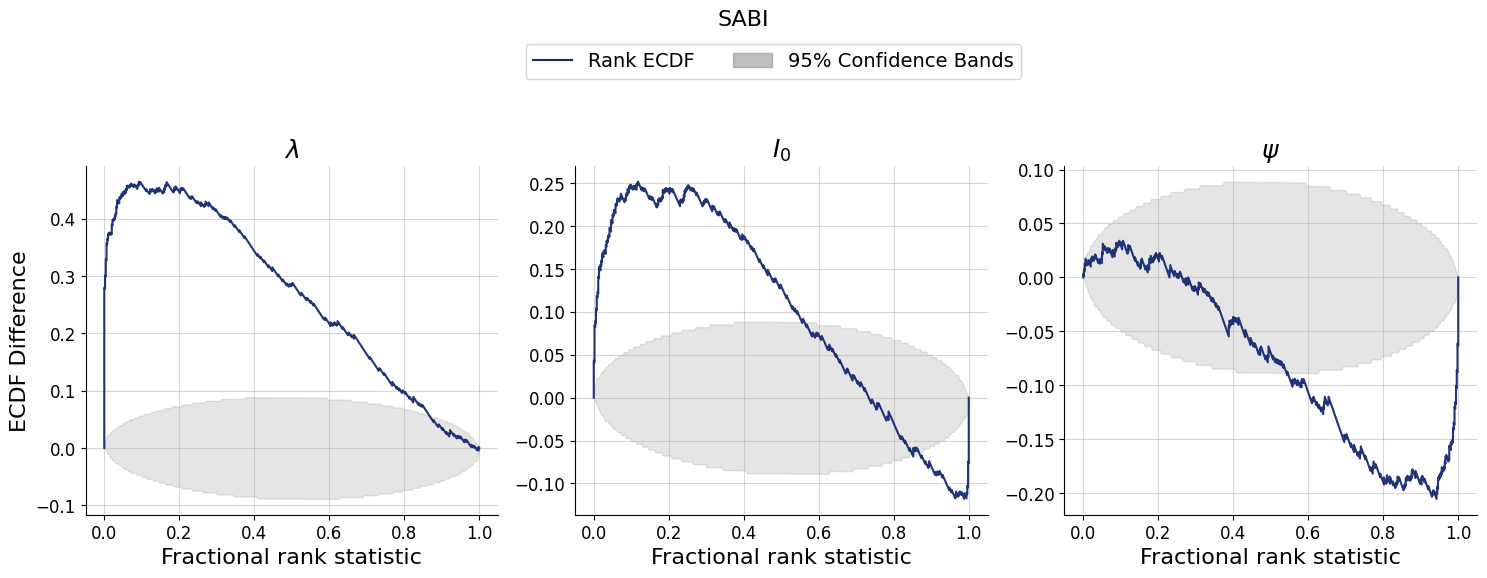

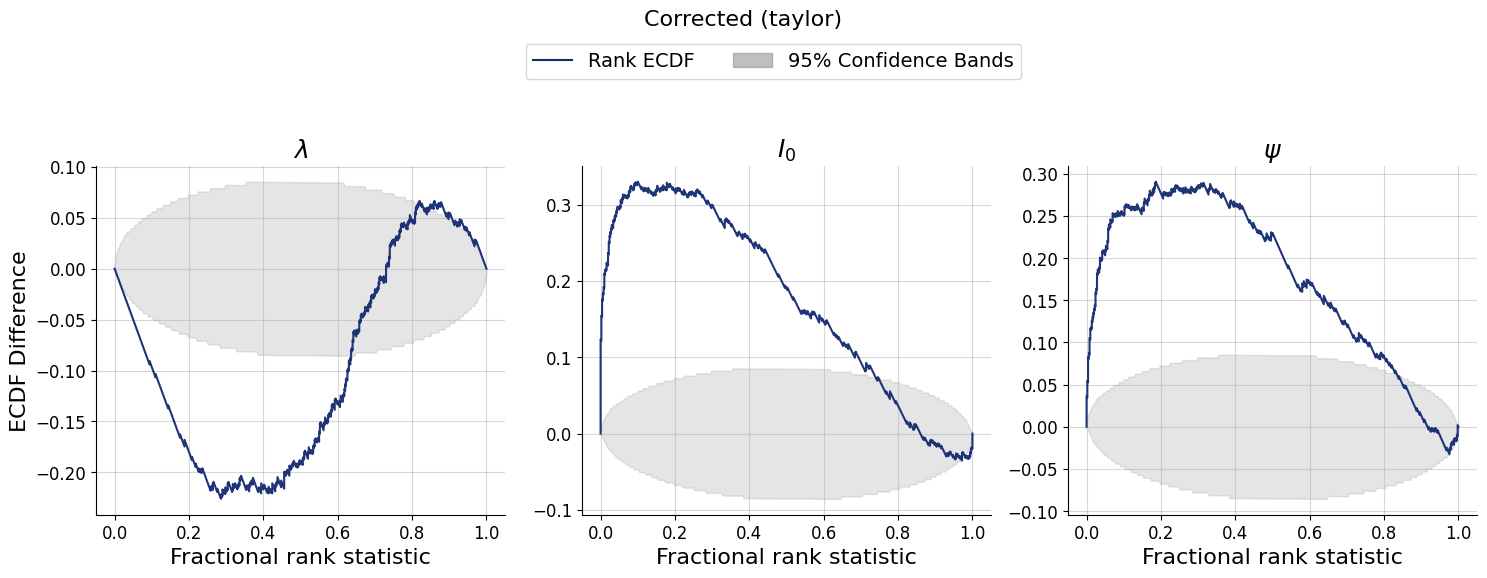

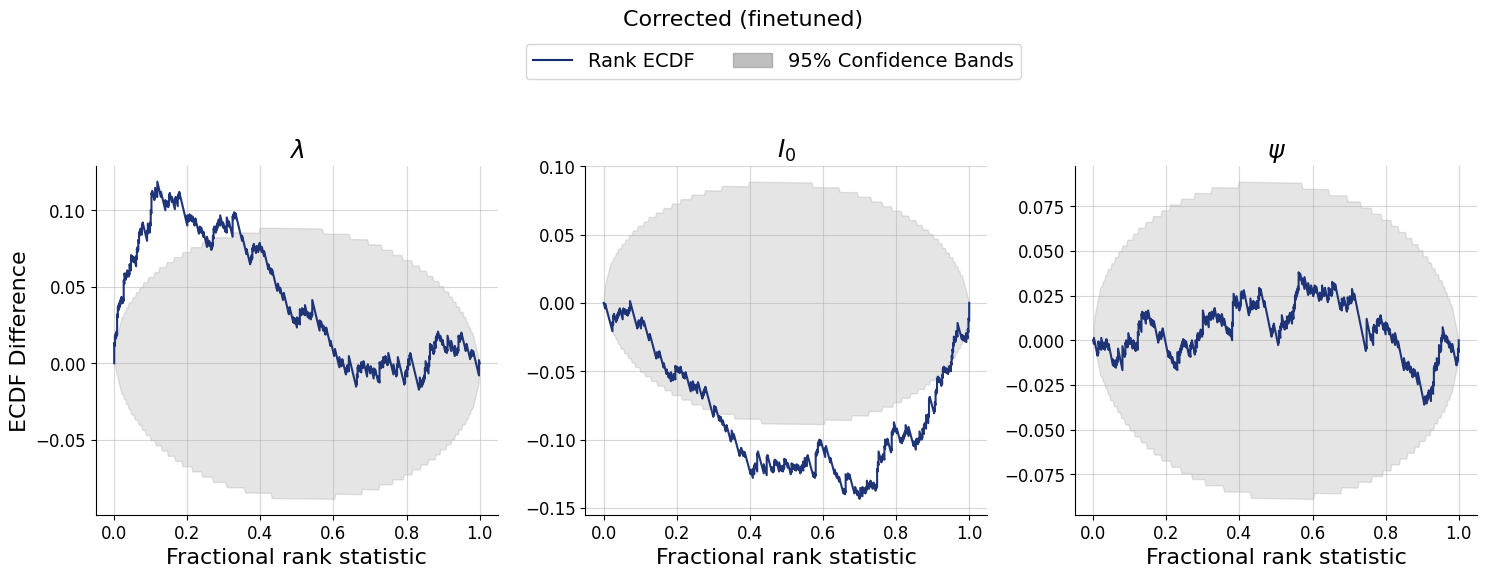

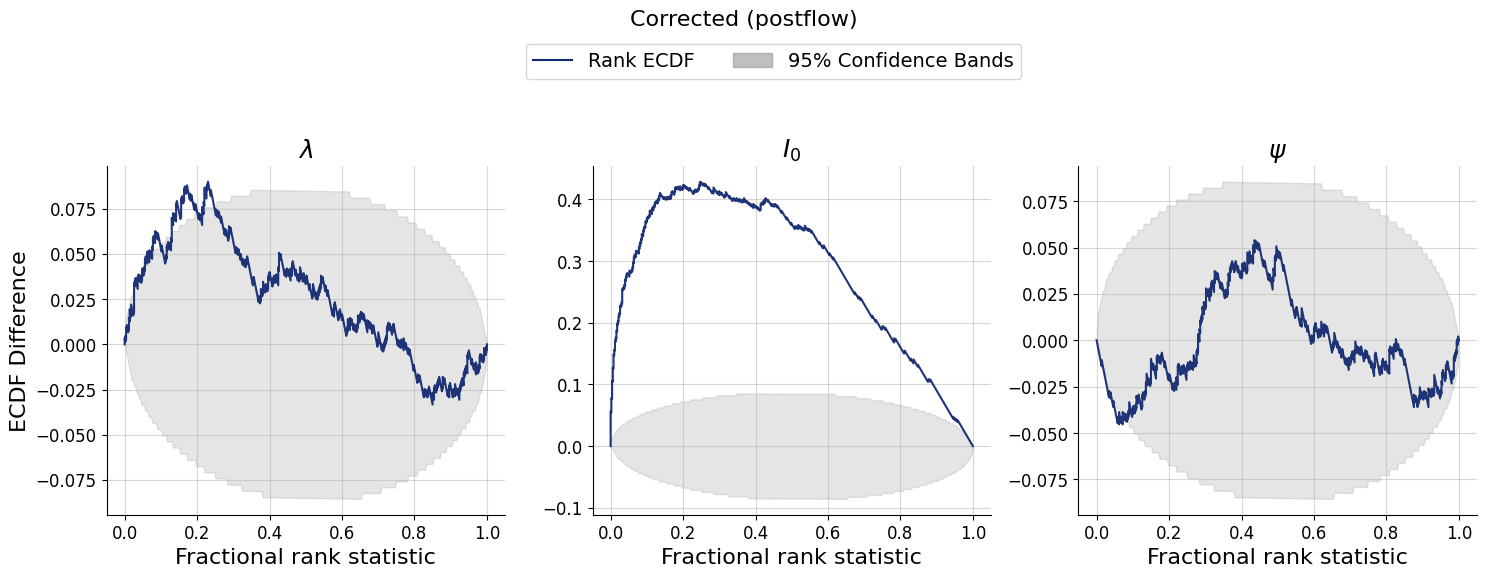

In [34]:
for wf_name, posterior_samples in posterior_samples_per_wf.items():
    print(wf_name)
    f = bfp.calibration_ecdf(posterior_samples, test_sims, difference=True, **BFPKW)
    f.suptitle(wf_name, y=1.15, fontsize=16)
    bfp_better_calibration_legend()
    if wf_name not in ["Full-Budget", "Low-Budget"]:
        img_path = IMG_OUT_DIR / f"rankECDF_misStrength={CONFIG.misspec_strength}_{wf_name}"
    else:
        img_path = IMG_OUT_DIR / f"rankECDF_{wf_name}"
    plotting.savefig(plt.gcf(), img_path)

### Inferential Adequacy (Global)

Depending on the application, it might be interesting to see how well summaries of the full posterior (e.g., means, medians) recover the assumed true parameter values. We can test this <em>in silico</em> via the `plots.recovery` function in the `diagnostics` module. For instance, we can compare how well posterior means recover the true parameter (i.e., posterior z-score, https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html):

Full-Budget
Low-Budget
SABI
Corrected (taylor)
Corrected (finetuned)
Corrected (postflow)


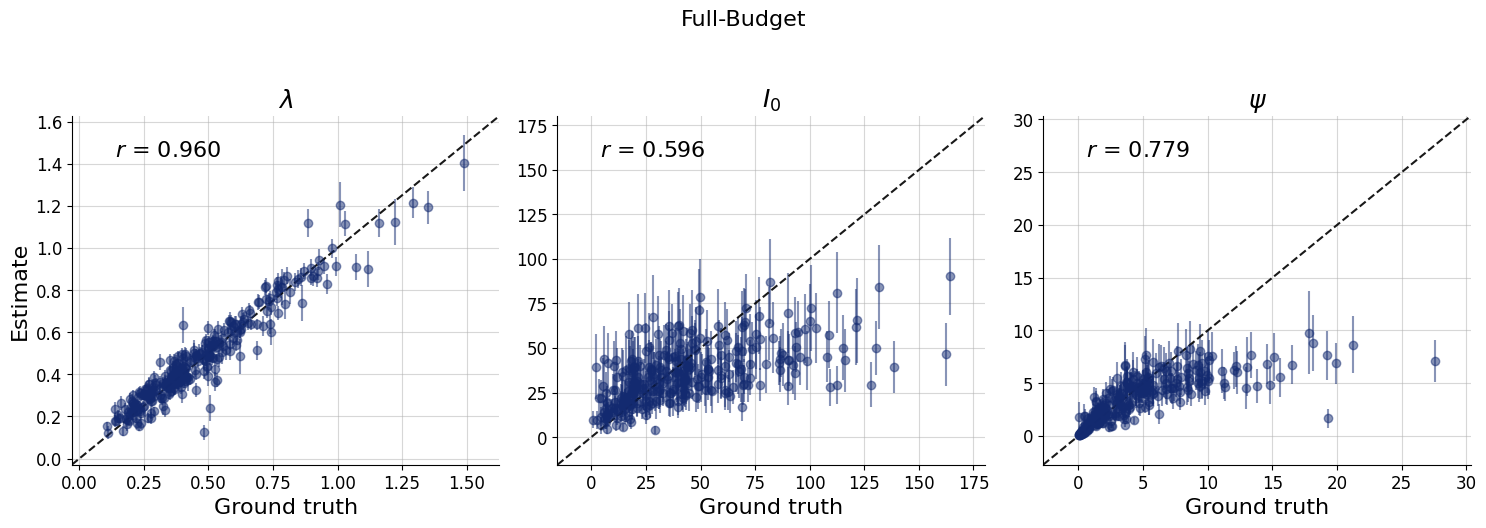

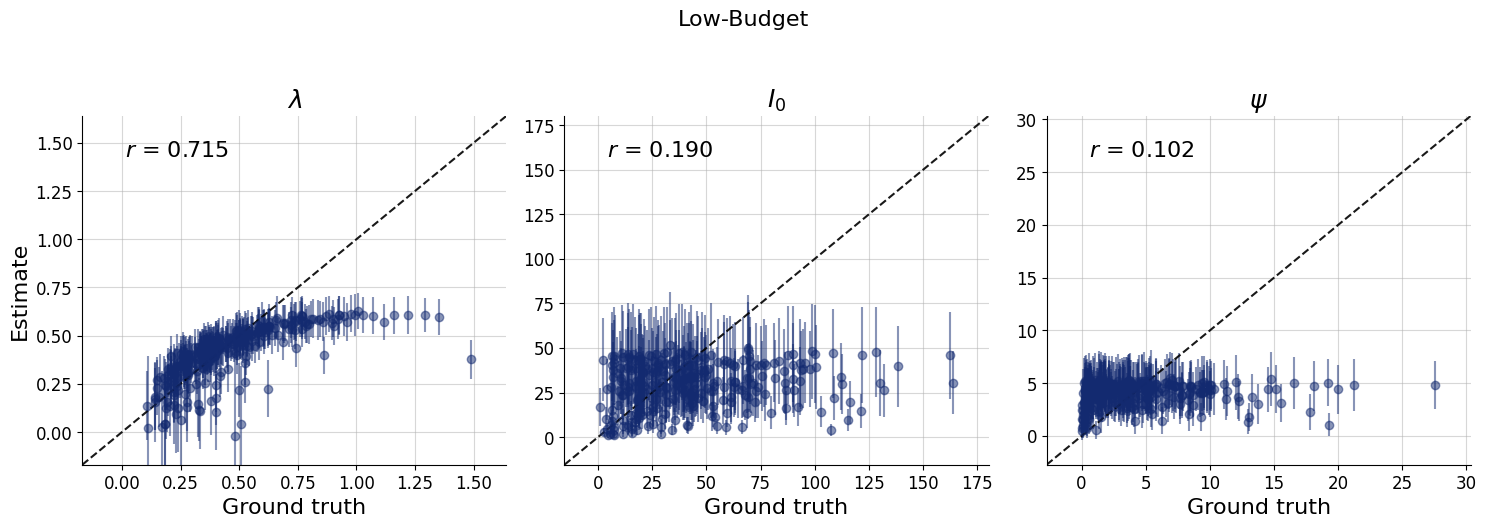

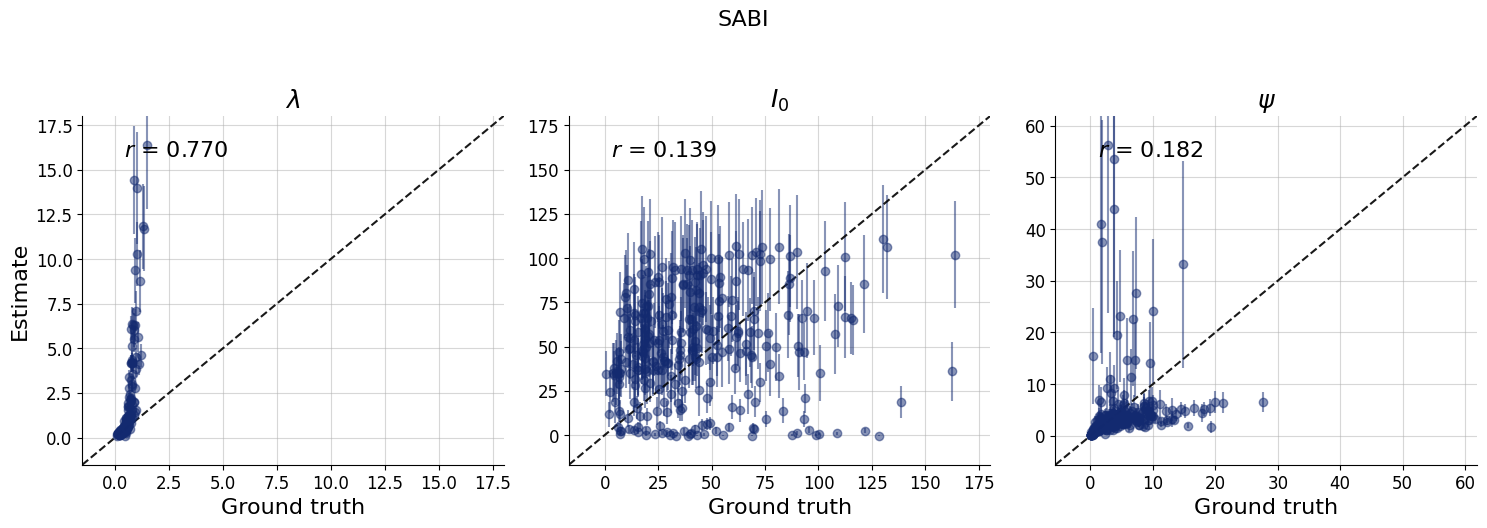

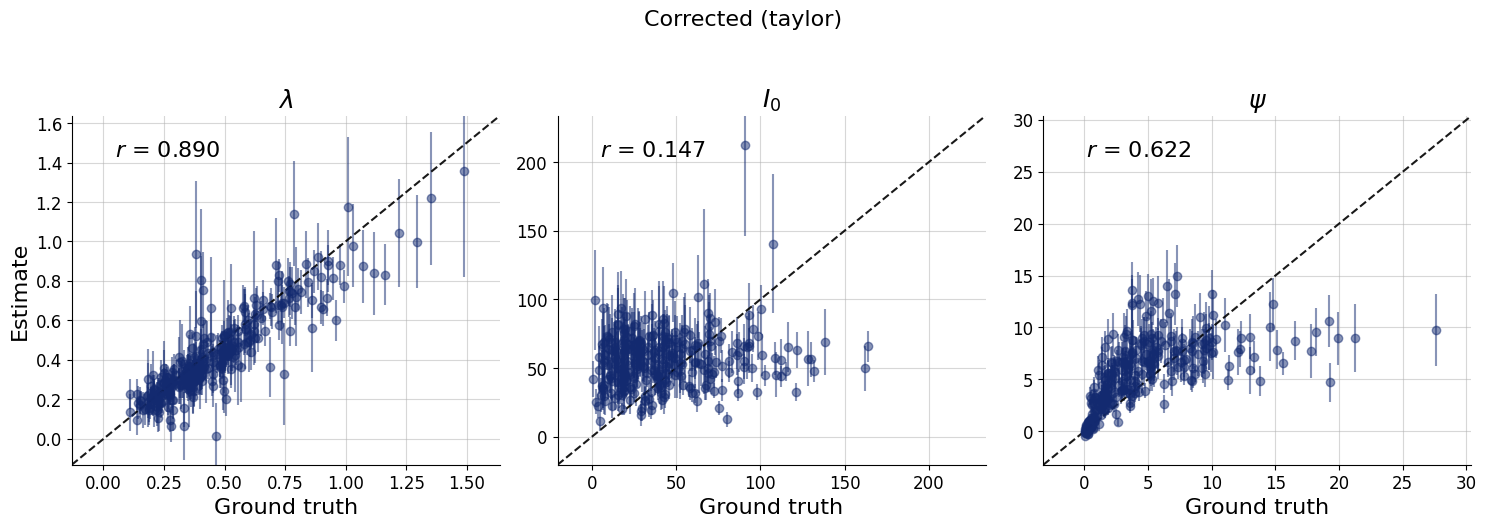

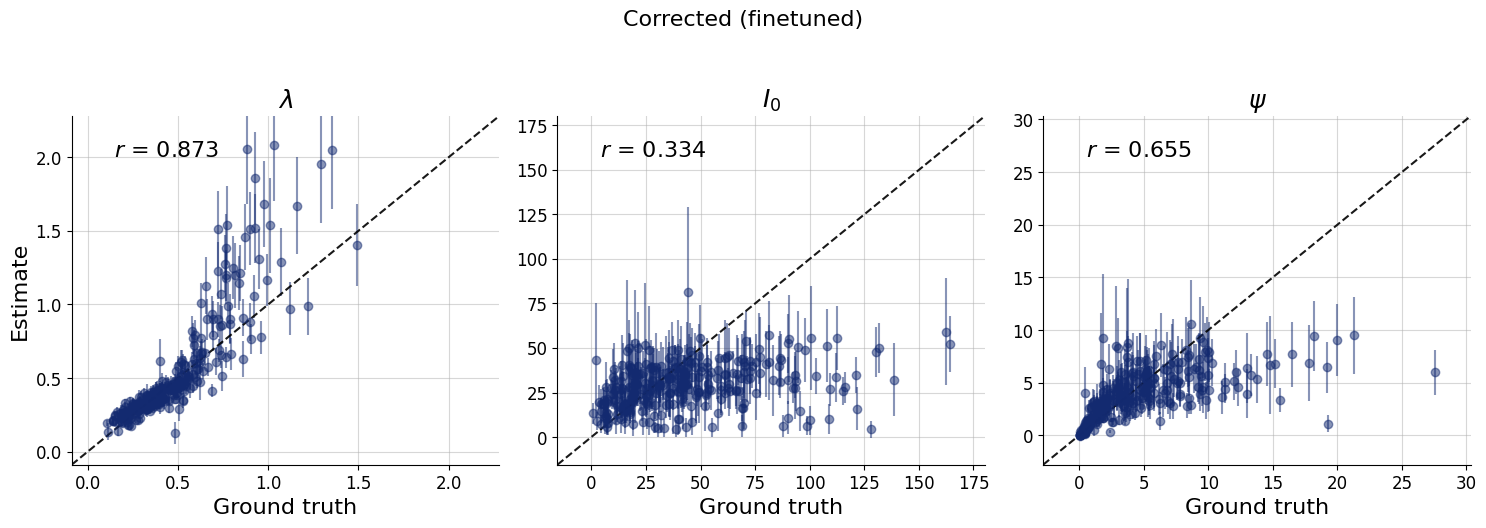

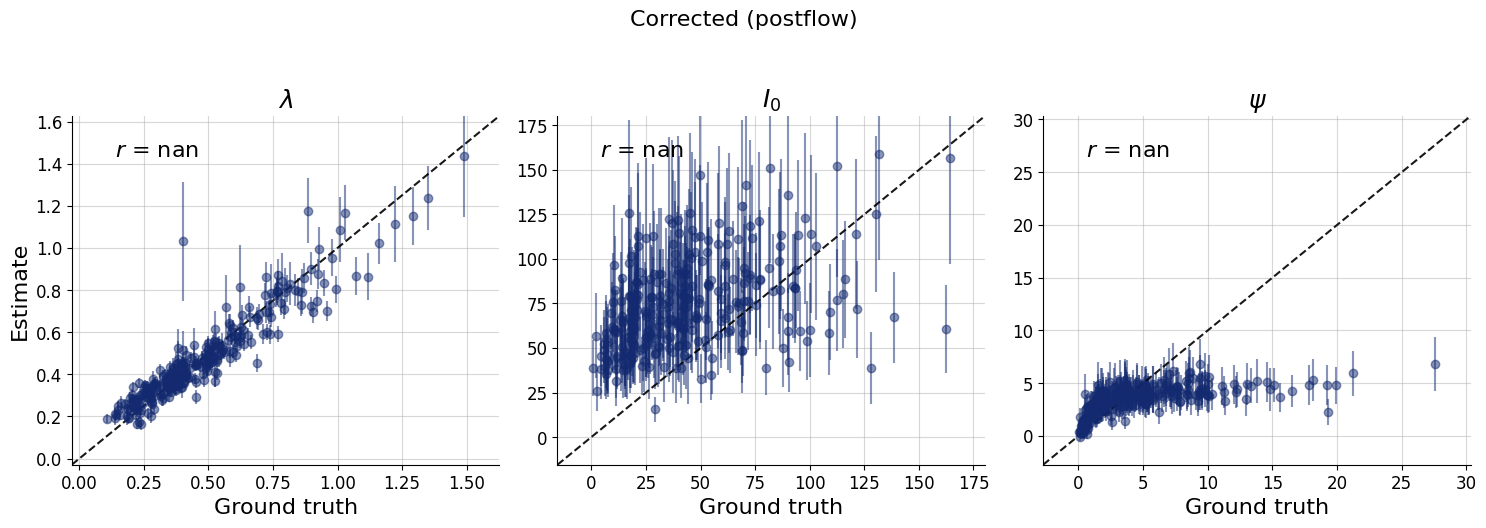

In [35]:
for wf_name, posterior_samples in posterior_samples_per_wf.items():
    print(wf_name)
    f = bfp.recovery(posterior_samples, test_sims, **BFPKW)
    f.suptitle(wf_name, y=1.05, fontsize=16)
    if wf_name not in ["Full-Budget", "Low-Budget"]:
        img_path = IMG_OUT_DIR / f"recovery_misStrength={CONFIG.misspec_strength}_{wf_name}"
    else:
        img_path = IMG_OUT_DIR / f"recovery_{wf_name}"
    plotting.savefig(plt.gcf(), img_path)

In [36]:
import numpy as np
import utils
importlib.reload(utils)
from utils import robust_mean

In [37]:
def wasserstein_metric(samples: dict[str, np.ndarray], inference_variables: dict[str, np.ndarray], variable_names, variable_keys):
    from scipy.stats import wasserstein_distance
    values = []
    for inf_var in samples.keys():
        if inf_var not in variable_keys:
            continue
        # normalize
        std = 1.0 #np.std(inference_variables[inf_var])
        mu = 0.0 #np.mean(inference_variables[inf_var])
        datasets = (inference_variables[inf_var] - mu) / std
        estimates = (samples[inf_var] - mu) / std
        # other idea for normalization
        # (which I take because then the values are closer to RMSE which uses a similar normalization)
        fac = (datasets.max() - datasets.min())

        _tmp_list = []
        for estimate, target in zip(estimates, datasets):
            dist = wasserstein_distance(estimate.squeeze(), target)/fac
            if np.isnan(dist) or np.isinf(dist):
                continue
            _tmp_list.append(dist)

        if len(_tmp_list) < len(estimates) // 2:
            # more than half the datasets had nans/inf
            values.append(np.nan)
        else:
            values.append(np.median(_tmp_list))

    return {"name": "Wasserstein", "values": values}

def _convert_metric(name, f):
    return lambda *args, **kwargs: {"name": name, "values": f(*args,**kwargs)["values"]}


from functools import partial
METRICS_DICT = {
    "4": wasserstein_metric,
    "1": _convert_metric("NRMSE", partial(bf.diagnostics.metrics.root_mean_squared_error, normalize=True, aggregation=robust_mean)),
    "3": _convert_metric("Calibration Error", bf.diagnostics.metrics.calibration_error),
    "2": _convert_metric("Posterior Contraction", partial(bf.diagnostics.metrics.posterior_contraction, aggregation=np.median)),
}

In [38]:
metric_df = pd.read_csv(OUT_DIR / "metrics.csv", index_col=None)

# metric_df = []
# for wf_name, wf in workflows.items():
#     for _ in range(4):
#         df = wf.compute_custom_diagnostics(
#             # test_data=test_sims,
#             test_data=workflow.simulate(num_datasets),
#             metrics=METRICS_DICT,
#             **BFPKW
#         ).T.reset_index().melt(
#             id_vars="index",
#             var_name='Parameter',
#             value_name='Metric Value'
#         ).rename(columns={'index': 'Metric'})
#         df["Workflow"] = wf_name
#         metric_df.append(df)
# metric_df = pd.concat(metric_df, ignore_index=True)
# print(len(metric_df))
# metric_df.head()

In [39]:
metric_df.query("Workflow == 'Corrected (postflow)' and Metric == 'NRMSE' and Parameter == '$I_0$'")

,Metric,Parameter,Metric Value,Workflow
245,NRMSE,$I_0$,2.684520e+10,Corrected (postflow)
257,NRMSE,$I_0$,8.171315e+24,Corrected (postflow)
269,NRMSE,$I_0$,5.218740e+29,Corrected (postflow)
281,NRMSE,$I_0$,2.243463e+29,Corrected (postflow)


In [40]:
metric_df.head()

,Metric,Parameter,Metric Value,Workflow
0,Wasserstein,$\lambda$,0.029969,Full-Budget
1,NRMSE,$\lambda$,0.059032,Full-Budget
2,Calibration Error,$\lambda$,0.023333,Full-Budget
3,Posterior Contraction,$\lambda$,0.961223,Full-Budget
4,Wasserstein,$I_0$,0.138547,Full-Budget


In [41]:
metric_df.to_csv(OUT_DIR / "metrics.csv", index=False)

In [42]:
workflow_attributes_df = pd.DataFrame({
    "name": [
        "Full-Budget",
        "Low-Budget",
        "SABI",
        "Corrected (finetuned)",
        "Corrected (taylor)",
        "Corrected (postflow)",
    ],
    "color": [[0]*3, [0.3]*3, [0.6]*3, "C0", "C1", "C2"],
    "hatch": ["", "", "", "/", "\\", "#"],
})
workflow_attributes_df

workflow_colors = {row["name"]: row["color"] for _, row in workflow_attributes_df.iterrows()}
workflow_hatches = {row["name"]: row["hatch"] for _, row in workflow_attributes_df.iterrows()}

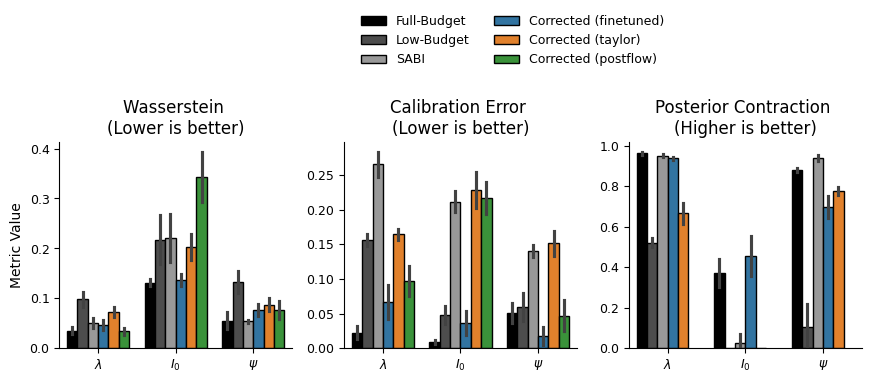

In [67]:
import seaborn as sns

metric_df = metric_df.query("Metric != 'NRMSE'")

CUSTOM_TITLES = {
    "Wasserstein": "\n(Lower is better)",
    # "NRMSE": "(Lower is better)",
    "Calibration Error": "\n(Lower is better)",
    "Posterior Contraction": "\n(Higher is better)",
}
col_order = list(CUSTOM_TITLES.keys())

g = sns.catplot(
    data=metric_df,#.sort_values(["Metric Value"]),
    kind="bar",
    col="Metric", col_wrap=3,
    x="Parameter",
    y="Metric Value",
    hue="Workflow",
    errorbar="sd",
    sharey=False,
    hue_order=workflow_attributes_df["name"],
    col_order=col_order,
    edgecolor="black",
    palette=workflow_colors,
    height=3.0,
    aspect=1,
    # gap=0.15,
)
g.set_axis_labels(x_var="")
sns.move_legend(
    g, "lower center",
    bbox_to_anchor=(.5, 1.1), ncol=2, title=None, frameon=False,
)

# Iterate through the axes and set custom titles
for ax, metric_name in zip(g.axes.flat, g.col_names):
    ax.set_ylim(bottom=0)
    if metric_name in CUSTOM_TITLES:
        ax.set_title(f"{metric_name} {CUSTOM_TITLES[metric_name]}")
    else:
        # Fallback for metrics not in custom_titles
        ax.set_title(f"{metric_name}")


img_path = IMG_OUT_DIR / f"metricBars_misStrength={CONFIG.misspec_strength}"
plt.show()
plotting.savefig(g.figure, img_path)

## Inference Phase <a class="anchor" id="inference_phase"></a>

We can now move on to using real data. This is easy, and since we are using an adapter, the same transformations applied during training will be applied during the inference phase.

In [44]:
def get_covid_posterior_samples(workflow):
    # Our real-data loader returns the time series as a 1D array
    obs_cases = load_data()

    # Note that we transform the 1D array into shape (1, T), indicating one time series
    samples = workflow.sample(conditions={"cases": obs_cases[None, :]}, num_samples=num_samples)

    # Convert into a nice format 2D data frame
    samples = workflow.samples_to_data_frame(samples)

    return samples, obs_cases

### Posterior Retrodictive Checks <a class="anchor" id="posterior_retrodictive_checks"></a>

These are also called <em>posterior predictive checks</em>, but here we want to explicitly highlight the fact that we are not predicting future data but testing the <strong>generative performance</strong> or <strong>re-simulation performance</strong> of the model. In other words, we want to test how well the simulator can reproduce the actually observed data given the parameter posterior $p(\theta \mid h(x_{1:T}))$. 

Here, we will create a custom function which plots the observed data and then overlays draws from the posterior predictive.

In [45]:
def plot_ppc(ax: plt.Axes, samples, obs_cases, logscale=True, color="#132a70"):
    """
    Helper function to perform some plotting of the posterior predictive.
    """

    # Grid and schmuck
    ax.grid(color="grey", linestyle="-", linewidth=0.25, alpha=0.5)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.minorticks_off()
    if logscale:
        ax.set_yscale("log")

    T = len(obs_cases)

    # Re-simulations
    sims = []
    total_skipped=0
    for i in range(samples.shape[0]):
        # Note - simulator returns 2D arrays of shape (T, 1), so we remove trailing dim
        try:
            sim_cases = stationary_SIR(*samples.values[i])
        except ValueError:
            total_skipped += 1
            continue
        sims.append(sim_cases["cases"])
    print(f"Skipped {total_skipped}/{samples.shape[0]} because bad posterior samples")
    sims = np.array(sims)

    # Compute quantiles for each t = 1,...,T
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)

    # Plot median predictions and observed data
    median_handle=ax.plot(np.median(sims, axis=0), label="Median predicted cases", color=color)[0]
    obs_handle=ax.plot(obs_cases, marker="8", label="Reported cases", color="red", linestyle="dashed", alpha=0.8, mec="k", ms=8)[0]

    # Add compatibility intervals (also called credible intervals)
    ci50_handle = ax.fill_between(range(T), qs_50[0], qs_50[1], color=color, alpha=0.5, label="50% CI")
    ci90_handle = ax.fill_between(range(T), qs_90[0], qs_90[1], color=color, alpha=0.3, label="90% CI")
    ci95_handle = ax.fill_between(range(T), qs_95[0], qs_95[1], color=color, alpha=0.1, label="95% CI")
    
    return [median_handle, obs_handle, ci50_handle, ci90_handle, ci95_handle]


We can now go on and plot the re-simulations (i.e., perform a posterior "predictive" check on the fitted data):

Skipped 0/500 because bad posterior samples
Skipped 0/500 because bad posterior samples
Skipped 0/500 because bad posterior samples
Skipped 0/500 because bad posterior samples
Skipped 0/500 because bad posterior samples
Skipped 0/500 because bad posterior samples


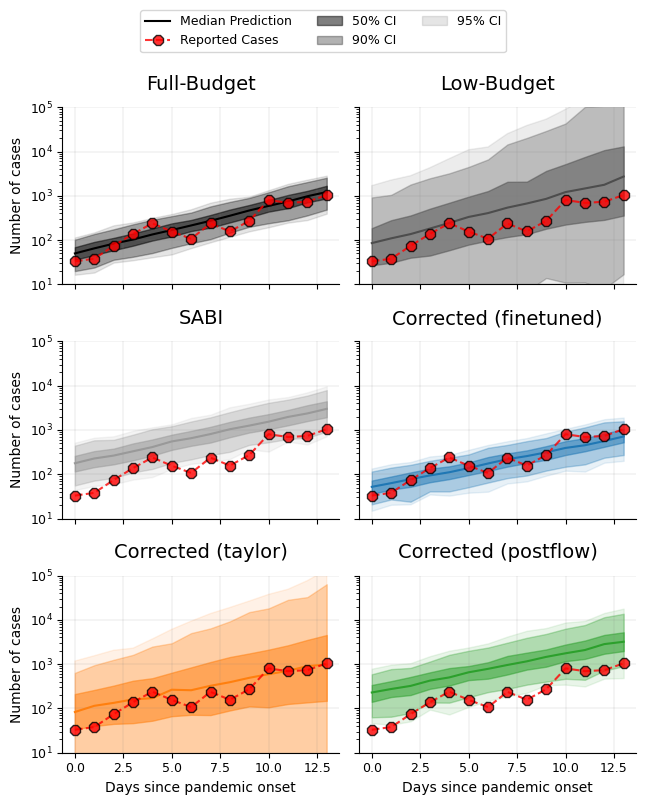

In [50]:
importlib.reload(plotting)
ncols=2
nrows=int(np.ceil(len(workflows) / ncols))
fig, axs = plt.subplots(nrows, ncols, figsize=plotting.figure_size(3, 1.75), sharex=True, sharey=True)
for i, wf_name in reversed(list(enumerate(workflow_attributes_df["name"].tolist()))):
    wf = workflows[wf_name]
    ax = axs.ravel()[i]
    handles = plot_ppc(ax, *get_covid_posterior_samples(wf), color=workflow_colors[wf_name])
    # ax.set_title(wf_name + " (Baseline)" if wf_name == "SABI", y=1.05, fontsize=14)
    ax.set_title(wf_name, y=1.05, fontsize=14)

import itertools
for row, col in itertools.product(range(nrows), range(ncols)):
    ax = axs[row, col]
    ax.set_ylim(10, 10**5)
    if row == nrows - 1:
        ax.set_xlabel("Days since pandemic onset")
    if col == 0:
        ax.set_ylabel("Number of cases")

fig.legend(handles, ["Median Prediction", "Reported Cases", "50% CI", "90% CI", "95% CI"], ncols=3, loc="upper center", bbox_to_anchor=(0.5, 1.075))
plt.tight_layout()
img_path = IMG_OUT_DIR / f"posteriorPredictive_misStrength={CONFIG.misspec_strength}"
plotting.savefig(plt.gcf(), img_path)

In [47]:
!say "Notebook Finished"